# library import

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


In [2]:
import re
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier


#import warnings
#warnings.filterwarnings(action='ignore')

In [3]:
from sklearn.metrics import f1_score

# macro f1 score 함수
def macro_f1_score(y_true, y_pred, n_classes = 26):
    f1_scores = []
    for c in range(n_classes):
        y_true_c = (y_true == c)
        y_pred_c = (y_pred == c)
        f1_c = f1_score(y_true_c, y_pred_c)
        f1_scores.append(f1_c)
    return np.mean(f1_scores)

# data load

In [4]:
!git clone https://github.com/jeongminia/Cancer-Classification.git
!unzip -qq '/content/Cancer-Classification/data/open.zip'
!unzip -qq '/content/Cancer-Classification/data/preprocessed_data.zip'

Cloning into 'Cancer-Classification'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 155 (delta 59), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (155/155), 12.72 MiB | 5.72 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [5]:
train = pd.read_csv('/content/preprocessed_train.csv')
test = pd.read_csv('/content/preprocessed_test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [6]:
print(train)
print(test)

      Unnamed: 0          ID  SUBCLASS  A2M  AAAS  AADAT  AARS1  ABAT  ABCA1  \
0              0  TRAIN_0000         8    1     1      1      1     1      1   
1              1  TRAIN_0001        19    1     1      1      1     1      1   
2              2  TRAIN_0002        20    1     1      1      1     1      1   
3              3  TRAIN_0003         9    1     1      1      1     1      1   
4              4  TRAIN_0004         6    1     1      1      1     1      1   
...          ...         ...       ...  ...   ...    ...    ...   ...    ...   
6196        6196  TRAIN_6196        13    1     1      1      1     1      1   
6197        6197  TRAIN_6197        11    1     1      1      1     1      1   
6198        6198  TRAIN_6198         4    1     1      1      1     1      1   
6199        6199  TRAIN_6199        22    1     1      1      1     1      1   
6200        6200  TRAIN_6200        20    1     1      1      1     1      1   

      ABCA2  ...  ZNF365  ZNF639  ZNF70

# data split

In [7]:
X = train.drop(columns=['Unnamed: 0','SUBCLASS', 'ID'])
y = train['SUBCLASS']

In [8]:
X

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,18
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,12
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,85
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,4
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,33
6197,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,8
6198,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,10,1,13
6199,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,5


In [9]:
y

,SUBCLASS
0,8
1,19
2,20
3,9
4,6
...,...
6196,13
6197,11
6198,4
6199,22


In [10]:
# 범주형 변수를 찾기
cat_features_indices = X.select_dtypes(include=['object']).columns

# 범주형 변수의 인덱스 찾기
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features_indices]

print("범주형 변수 인덱스:", cat_feature_indices)

범주형 변수 인덱스: []


In [65]:
# 데이터 분할 (각 클래스 비율 유지)
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # 각 클래스 비율 유지
)

In [94]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#"""
# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# 클래스 가중치 리스트 생성
sample_weights = np.array([class_weight_dict[label] for label in y_train])
#"""

# CatBoostClassifier 모델 생성
model = CatBoostClassifier(
    iterations=5000,                    # 훈련 반복 횟수
    learning_rate=0.1,                  # 학습률
    depth=6,                            # 트리 깊이
    cat_features=cat_feature_indices,   # 카테고리 변수
    task_type='GPU',                    # GPU 사용
    custom_metric=['F1'],               # 평가 지표로 F1 사용
    verbose=100,                        # 100번마다 결과 출력
    use_best_model=True,                # 검증 세트에서 가장 좋은 모델 사용
    early_stopping_rounds=200,          # 200회 동안 성능 향상이 없으면 멈춤
)

# 모델 훈련 (eval_set을 사용하여 중간 결과 평가)
model.fit(X_train, y_train, eval_set=(X_val, y_val), sample_weight=sample_weights)


# 최종 예측 및 결과 평가
y_pred = model.predict(X_val)

# Accuracy 및 Classification Report 출력
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# 매크로 F1 스코어 계산 및 출력
macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f"Final Macro F1 Score: {macro_f1:.2f}")

0:	learn: 0.3300377	test: 0.2527510	best: 0.2527510 (0)	total: 382ms	remaining: 31m 48s
100:	learn: 0.4532696	test: 0.3214427	best: 0.3214427 (100)	total: 22.6s	remaining: 18m 15s
200:	learn: 0.4948928	test: 0.3459013	best: 0.3464058 (192)	total: 40.2s	remaining: 16m
300:	learn: 0.5181800	test: 0.3538343	best: 0.3538343 (298)	total: 54.8s	remaining: 14m 14s
400:	learn: 0.5357576	test: 0.3549010	best: 0.3568223 (360)	total: 1m 7s	remaining: 12m 54s
500:	learn: 0.5561523	test: 0.3614712	best: 0.3614712 (499)	total: 1m 18s	remaining: 11m 48s
600:	learn: 0.5662485	test: 0.3617821	best: 0.3637703 (540)	total: 1m 27s	remaining: 10m 38s
700:	learn: 0.5732582	test: 0.3647552	best: 0.3647552 (684)	total: 1m 36s	remaining: 9m 54s
800:	learn: 0.5831864	test: 0.3629592	best: 0.3647986 (722)	total: 1m 47s	remaining: 9m 21s
900:	learn: 0.5953379	test: 0.3633829	best: 0.3647986 (722)	total: 1m 54s	remaining: 8m 41s
bestTest = 0.3647985973
bestIteration = 722
Shrink model to first 723 iterations.
Accu

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# confusion matrix 계산
cm = confusion_matrix(y_val, y_pred)

# confusion matrix를 DataFrame으로 변환 (선택 사항)
cm_df = pd.DataFrame(cm, index=np.unique(y_val), columns=np.unique(y_val))

# confusion matrix 출력
print(cm_df)

    0   1   2   3   4   5   6   7   8   9   ...  16  17  18  19  20  21  22  \
0    6   1   0   0   0   0   0   0   0   0  ...   0   0   1   1   1   0   1   
1    0   6   0   1   0   0   0   3   0   0  ...   0   0   0   0   0   3   1   
2    2   0  48   9   0   0   1   4   0   0  ...   1   9  14   5   0   1  13   
3    0   2   1   4   0   0   0   0   0   0  ...   0   0   2   1   1   0  11   
4    0   0   0   0  25   0   0   0   0   0  ...   0   0   1   0   2   4   2   
5    0   0   0   0   0   1   0   1   0   0  ...   0   0   0   0   2   0   1   
6    0   0   5   1   0   0  13   1   0   0  ...   1   0   2   2   0   0  11   
7    0   0   1   8   0   0   1   7   0   0  ...   2   0   1   0   0   5   2   
8    0   2   1   2   0   1   2   1   0  32  ...   0   5   9   5   0   0  35   
9    0   0   0   1   0   0   1   0   3  33  ...   0   0   9   2   0   0  14   
10   0   0   0   0   0   0   0   0   0   0  ...   0   9   1   0   0   0   0   
11   0   0   0   0   0   0   2   0   0   0  ...   0 

<Figure size 1200x800 with 0 Axes>

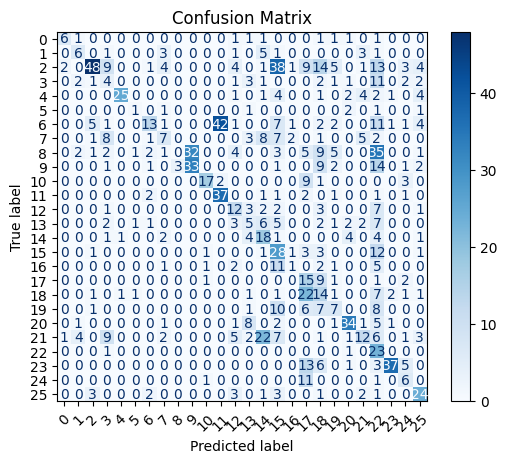

In [96]:
# confusion matrix 시각화
plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_val))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

In [82]:
# 최적 모델 저장
model.save_model('best_model.cbm')

In [83]:
test

,ID,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX,mutation_cnt
0,TEST_0000,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,81
1,TEST_0001,1,1,1,1,1,10,1,1,1,...,1,1,1,1,100000,1,1,1,1,523
2,TEST_0002,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,5
3,TEST_0003,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,6
4,TEST_0004,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,TEST_2541,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,90
2542,TEST_2542,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,11
2543,TEST_2543,1,1,1,1,1,10,1,10,10,...,10,1,1,1,1,20,10,1,1,2231
2544,TEST_2544,1,1,1,1,1,1,1,1,10,...,1,1,1,1,1,1,1,1,1,4


In [84]:
X_test = test.drop(columns=['ID'])

# 저장된 모델 불러오기
loaded_model = CatBoostClassifier()
loaded_model.load_model('best_model.cbm')

# 예측 수행
predictions = loaded_model.predict(X_test)

In [85]:
# 전처리 전 train qnffjdhrl
train_ori = pd.read_csv('/content/train.csv')

# SUBCLASS 가 범주형이기 때문에 LabelEncoder 사용
le_subclass = LabelEncoder()
train_ori['SUBCLASS'] = le_subclass.fit_transform(train_ori['SUBCLASS'])

# 변환된 레이블 확인
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

original_labels = le_subclass.inverse_transform(predictions)
print("original_labels의 길이:", len(original_labels))
print("submisson의 길이:", len(submission))

원래 레이블: ACC, 변환된 숫자: 0
원래 레이블: BLCA, 변환된 숫자: 1
원래 레이블: BRCA, 변환된 숫자: 2
원래 레이블: CESC, 변환된 숫자: 3
원래 레이블: COAD, 변환된 숫자: 4
원래 레이블: DLBC, 변환된 숫자: 5
원래 레이블: GBMLGG, 변환된 숫자: 6
원래 레이블: HNSC, 변환된 숫자: 7
원래 레이블: KIPAN, 변환된 숫자: 8
원래 레이블: KIRC, 변환된 숫자: 9
원래 레이블: LAML, 변환된 숫자: 10
원래 레이블: LGG, 변환된 숫자: 11
원래 레이블: LIHC, 변환된 숫자: 12
원래 레이블: LUAD, 변환된 숫자: 13
원래 레이블: LUSC, 변환된 숫자: 14
원래 레이블: OV, 변환된 숫자: 15
원래 레이블: PAAD, 변환된 숫자: 16
원래 레이블: PCPG, 변환된 숫자: 17
원래 레이블: PRAD, 변환된 숫자: 18
원래 레이블: SARC, 변환된 숫자: 19
원래 레이블: SKCM, 변환된 숫자: 20
원래 레이블: STES, 변환된 숫자: 21
원래 레이블: TGCT, 변환된 숫자: 22
원래 레이블: THCA, 변환된 숫자: 23
원래 레이블: THYM, 변환된 숫자: 24
원래 레이블: UCEC, 변환된 숫자: 25
original_labels의 길이: 2546
submisson의 길이: 2546


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [86]:
original_labels = original_labels.ravel()
submission["SUBCLASS"] = original_labels

In [87]:
submission.to_csv('submission.csv', encoding='UTF-8-sig', index=False)